In [1]:
import pod5
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12
sys.path.insert(0, '/private/groups/brookslab/gabai/tools/NEMO/src/')
from predict import *
from plot import *
import importlib
from qc import *
from findWellPosGenes import *
importlib.reload(sys.modules['findWellPosGenes'])
from findWellPosGenes import *

In [28]:
dt_outpath = '../data/'
fig_outpath = '../figures/'

## Figure3A: refer to 

In [120]:
# read well positioned genes
nuclei_rep1 = '../data/4_dorado_20190429_chrom_well_positioned_genes_cov20_cor0.6_var8000.bed'
nuclei_rep1_gene ={}
with open(nuclei_rep1) as infile:
    for line in infile:
        line=line.strip().split('\t')
        chr, start, end, genename = line[0], line[1], line[2], line[3]
        nuclei_rep1_gene[genename] = f'{chr}:{start}-{end}'
print(f'n genes: {len(nuclei_rep1_gene)}')

n genes: 327


In [121]:
# read well positioned genes
nuclei_rep2 = '../data/4_dorado_20210615_chrom_well_positioned_genes_cov25_cor0.6_var9000.bed'
nuclei_rep2_gene ={}
with open(nuclei_rep2) as infile:
    for line in infile:
        line=line.strip().split('\t')
        chr, start, end, genename = line[0], line[1], line[2], line[3]
        nuclei_rep2_gene[genename] = f'{chr}:{start}-{end}'
print(f'n genes: {len(nuclei_rep2_gene)}')

n genes: 219


In [122]:
# read well positioned genes
sphe = '../data/4_dorado_202205_sphe_chrom__well_positioned_genes_cov10_cor0.5_var5000.bed'
sphe_gene ={}
with open(sphe) as infile:
    for line in infile:
        line=line.strip().split('\t')
        chr, start, end, genename = line[0], line[1], line[2], line[3]
        sphe_gene[genename] = f'{chr}:{start}-{end}'
print(f'n genes: {len(sphe_gene)}')

n genes: 119


In [123]:
# get shared well-positioned genes between 2 replicates
shared_nuclei_genes = list(set(nuclei_rep1_gene.keys()) & set(nuclei_rep2_gene.keys()))
print(len(shared_nuclei_genes))
# shared_nuclei_genes = list(set(nuclei_rep1_gene.keys()) & set(nuclei_rep2_gene.keys()) & set(sphe_gene.keys()))
# print(len(shared_nuclei_genes))
pregions ={}
for gene in nuclei_rep1_gene:
    if gene in shared_nuclei_genes:
        pregions[gene] = nuclei_rep1_gene[gene]

33


In [124]:
# get single reads
predfile = '/private/groups/brookslab/gabai/projects/Add-seq/data/chrom/modPredict/240905_prediction/240912_dorado_20190429_chrom.tsv'
strand = ''
outpath = dt_outpath
na_thred = 0.2
max_meth = 200
prefix = '6_all_33_gene_tss_modifications'

mtx, readnames, strands, genes = [], [], [], []

for gene, pregion in pregions.items():
    
    print(f'start processing gene {gene}...')
    
    chrom = pregion.split(':')[0]
    locus = pregion.split(':')[1].split('-')
    pstart, pend = int(locus[0]), int(locus[1])
    with open(predfile, 'r') as infile:
        for line in tqdm(infile):
            thischrom = line.strip().split('\t')[1]
            if thischrom!= chrom:
                continue
            thisread = line.strip().split('\t')[0]
            thisstrand = 1 if line.strip().split('\t')[2] == '+' else -1
            if strand:
                if thisstrand != strand:
                    continue
            start = int(line.strip().split('\t')[3])
            scores = line.strip().split('\t')[-1]
            scores = [float(i) for i in scores.split(',')]
            
            sortedread = [(start+i,j) for i, j in enumerate(scores)]
            if sortedread[0][0] > pend or sortedread[-1][0] < pstart: continue
            
            pos_scores = {i:-1 for i in range(pstart, pend+1)}
            poss = [i[0] for i in sortedread]
            
            left = bisect_left(poss, pstart)
            
            for i in range(left, len(sortedread)):
                pos, score = sortedread[i]
                if pos > pend:
                    break
                if pos not in pos_scores:
                    continue
                pos_scores[pos] = score
            thisscores = np.array([v for v in pos_scores.values()])
            if np.sum(thisscores) != -1*len(thisscores):
                mtx.append(thisscores)
                readnames.append(thisread)
                strands.append(thisstrand)
                genes.append(gene)
    print(f'finished processing gene {gene}...')

mtx = np.array(mtx, dtype = float)
mtx[mtx==-1] = np.nan
readnames = np.array(readnames, dtype = str)
strands = np.array(strands, dtype = int)
genes = np.array(genes, dtype = str)

print('number of reads before filtering:', len(readnames))
print(f'filtering reads with more than {na_thred} NA...')
little_na = np.invert(np.isnan(mtx).sum(axis = 1)>(mtx.shape[1]*na_thred))
mtx = mtx[little_na,:]
readnames = readnames[little_na]
strands = strands[little_na]
genes = genes[little_na]
print(f'number of reads kept: {len(readnames)}', )
print(f'filtering hyper-methylated reads...')
hyper_meth= np.invert(np.nanmean(mtx, axis = 1)>max_meth)
mtx = mtx[hyper_meth,:]
readnames = readnames[hyper_meth]
strands = strands[hyper_meth]
genes = genes[hyper_meth]
print(f'number of reads kept: {len(readnames)}')

outfile = outpath + prefix + '.mtx'
print('writing output to file: ', outfile)
mtxFh = open(outfile, 'w')
for line in mtx:
    mtxFh.write(','.join(np.array(line, dtype = str)) + '\n')
mtxFh.close()

start processing gene zz-YIL161W...


58289it [00:22, 2600.30it/s]


finished processing gene zz-YIL161W...
start processing gene RPS1A...


58289it [00:33, 1720.39it/s]


finished processing gene RPS1A...
start processing gene RIB3...


58289it [00:24, 2332.32it/s] 


finished processing gene RIB3...
start processing gene GLE1...


58289it [00:22, 2577.83it/s] 


finished processing gene GLE1...
start processing gene RIB5...


58289it [00:16, 3588.04it/s] 


finished processing gene RIB5...
start processing gene TOR2...


58289it [00:13, 4477.16it/s] 


finished processing gene TOR2...
start processing gene ALR2...


58289it [00:10, 5779.24it/s] 


finished processing gene ALR2...
start processing gene RPL5...


58289it [00:16, 3444.69it/s] 


finished processing gene RPL5...
start processing gene VMA6...


58289it [00:24, 2382.18it/s] 


finished processing gene VMA6...
start processing gene RPN7...


58289it [00:16, 3558.35it/s] 


finished processing gene RPN7...
start processing gene ATG8...


58289it [00:15, 3685.15it/s] 


finished processing gene ATG8...
start processing gene DBP8...


58289it [00:12, 4525.18it/s] 


finished processing gene DBP8...
start processing gene APC1...


58289it [00:15, 3797.31it/s] 


finished processing gene APC1...
start processing gene VPS75...


58289it [00:15, 3859.73it/s] 


finished processing gene VPS75...
start processing gene SEC2...


58289it [00:16, 3587.36it/s] 


finished processing gene SEC2...
start processing gene HIS3...


58289it [00:18, 3168.77it/s] 


finished processing gene HIS3...
start processing gene SNU66...


58289it [00:19, 2971.74it/s] 


finished processing gene SNU66...
start processing gene SHE9...


58289it [00:30, 1912.60it/s] 


finished processing gene SHE9...
start processing gene LDS1...


58289it [00:09, 6400.87it/s] 


finished processing gene LDS1...
start processing gene SIR1...


58289it [00:13, 4434.16it/s] 


finished processing gene SIR1...
start processing gene DUR3...


58289it [00:12, 4691.14it/s] 


finished processing gene DUR3...
start processing gene ECM25...


58289it [00:15, 3717.58it/s] 


finished processing gene ECM25...
start processing gene PIM1...


58289it [00:19, 3067.72it/s] 


finished processing gene PIM1...
start processing gene BNA5...


58289it [00:28, 2070.34it/s] 


finished processing gene BNA5...
start processing gene UTP18...


58289it [00:15, 3740.71it/s] 


finished processing gene UTP18...
start processing gene SLM1...


58289it [00:11, 5147.33it/s] 


finished processing gene SLM1...
start processing gene IBA57...


58289it [00:15, 3831.10it/s] 


finished processing gene IBA57...
start processing gene BUD20...


58289it [00:28, 2079.30it/s] 


finished processing gene BUD20...
start processing gene RTF1...


58289it [00:17, 3340.47it/s] 


finished processing gene RTF1...
start processing gene SHE3...


58289it [00:14, 3909.17it/s] 


finished processing gene SHE3...
start processing gene SSK22...


58289it [00:09, 6061.30it/s] 


finished processing gene SSK22...
start processing gene MRPS9...


58289it [00:16, 3493.22it/s] 


finished processing gene MRPS9...
start processing gene RRT14...


58289it [00:11, 5018.59it/s] 


finished processing gene RRT14...
number of reads before filtering: 1054
filtering reads with more than 0.2 NA...
number of reads kept: 753
filtering hyper-methylated reads...
number of reads kept: 722
writing output to file:  ../data/6_all_33_gene_tss_modifications.mtx


In [125]:
outfile2 = outpath + prefix + '_rowannot.tsv'
outf = open(outfile2, 'w')
for i,j,k in zip(readnames, strands, genes):
    outf.write(f'{i}\t{j}\t{k}\n')
outf.close()

## no clustering

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 722/722 [17:00<00:00,  1.41s/it]


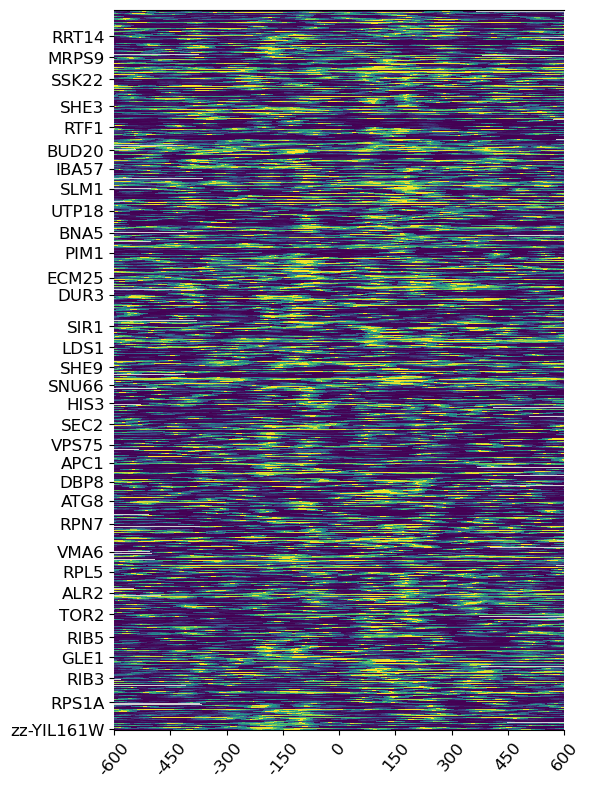

In [126]:
plt.figure(figsize=(5, 8))
pstart, pend = (-600, 600)
xticks_space = 150
ax = plt.axes((0.1, 0.1, 0.9, 0.9))
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(ticks= np.arange(pstart, pend+1, xticks_space))
ax.set_xticklabels(ax.get_xticks(), rotation = 50)
ax.set_xlim(pstart, pend)
height = (1, 1)
bottom=0
tick_yaxis, label_yaxis = [],[]
total, count = np.zeros(mtx.shape[1], dtype = int), np.zeros(mtx.shape[1], dtype = int)
(R,G,B) = colorMap(palette = 'viridis', log_scale=False)
thisgene = ''

for i in tqdm(range(mtx.shape[0])):
    left = -600
    if thisgene != genes[i]:
        tick_yaxis.append(bottom)
        label_yaxis.append(genes[i])
        thisgene = genes[i]
    for j in range(mtx.shape[1]):
        score = mtx[i, j]
        if not np.isnan(score):
            count[j] += score
            total[j] += 1
        # no score at this position
        if np.isnan(score):
            col = 'lightgray'
        else:
            color = int((score/256)*100)
            col=(R[color],G[color],B[color])
        thisalpha = 1
        rectangle = mplpatches.Rectangle([left, bottom-(height[0]*0.5)], 1, height[0], 
                                         facecolor = col, edgecolor = 'silver', linewidth = 0, alpha=thisalpha)
        ax.add_patch(rectangle)
        left += 1
    bottom +=height[0]

aggregate = np.divide(np.divide(count, total), 256)
if np.max(total) < 1:
    aggregate = np.zeros(mtx.shape[1])
ax.bar(np.arange(pstart, pend+1), aggregate, bottom=bottom, width = 1.0, color = 'tab:blue')
ax.set_yticks(ticks = tick_yaxis, labels = label_yaxis)
ax.set_ylim(0-0.5*height[0], bottom)

plt.savefig(fig_outpath+ f'6_top_well_positioned_genes.pdf', bbox_inches='tight')

## kmeans clustering of reads within each gene

In [127]:
import pandas as pd
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.impute import SimpleImputer

In [128]:
if np.isnan(mtx).sum() != 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    new_mtx = imp.fit_transform(mtx)
else:
    new_mtx = mtx

df = pd.DataFrame(new_mtx)
df['gene'] = genes  # Add the gene annotation to the matrix as a new column

# Group the matrix by gene
grouped_by_gene = df.groupby('gene')

# Function for KMeans clustering for each gene
def kmeans_clustering_for_gene(gene_group, n_clusters=3):
    # Exclude the 'gene' column for clustering
    gene_reads = gene_group.drop(columns=['gene'])
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(gene_reads)
    
    # Add the cluster labels as a new column
    gene_group['cluster'] = clusters
    
    # Sort the rows by cluster labels
    sorted_gene_group = gene_group.sort_values(by='cluster')
    
    return sorted_gene_group.drop(columns=['cluster'])  # Drop the cluster column after sorting

# Function for hierarchical clustering for each gene
def hierarchical_clustering_for_gene(gene_group, method='ward', n_clusters=3):
    # Exclude the 'gene' column for clustering
    gene_reads = gene_group.drop(columns=['gene'])
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(gene_reads, method=method)
    
    # Get the flat clusters based on n_clusters
    clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    
    # Add the cluster labels as a new column
    gene_group['cluster'] = clusters
    
    # Sort the rows by cluster labels
    sorted_gene_group = gene_group.sort_values(by='cluster')
    
    return sorted_gene_group.drop(columns=['cluster'])  # Drop the cluster column after sorting

# 1. Apply clustering on each gene group and collect sorted groups
sorted_groups, clustered_genes = [], []

for gene_name, gene_group in grouped_by_gene:
    print(f"Clustering for {gene_name}")
    
    # Choose KMeans or Hierarchical clustering
    sorted_gene_group = kmeans_clustering_for_gene(gene_group, n_clusters=3)
    # Alternatively, use hierarchical clustering:
    # sorted_gene_group = hierarchical_clustering_for_gene(gene_group, n_clusters=3)

    # Append the sorted group to the list
    sorted_groups.append(sorted_gene_group.drop(columns=['gene']))  # Remove 'gene' column

    clustered_genes.extend([gene_name] * len(sorted_gene_group))
# 2. Concatenate all sorted groups back into one matrix
clustered_mtx = pd.concat(sorted_groups, axis=0).values  # Convert to numpy array

# The final output matrix
print("clustered matrix shape:", clustered_mtx.shape)

Clustering for ALR2
Clustering for APC1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for ATG8
Clustering for BNA5


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for BUD20
Clustering for DBP8


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for DUR3
Clustering for ECM25


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for GLE1
Clustering for HIS3


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for IBA57
Clustering for LDS1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for MRPS9
Clustering for PIM1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for RIB3
Clustering for RIB5


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for RPL5
Clustering for RPN7


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for RPS1A
Clustering for RRT14


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for RTF1
Clustering for SEC2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for SHE3
Clustering for SHE9


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for SIR1
Clustering for SLM1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for SNU66
Clustering for SSK22


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for TOR2
Clustering for UTP18


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for VMA6
Clustering for VPS75


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for zz-YIL161W
clustered matrix shape: (722, 1201)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 722/722 [15:56<00:00,  1.32s/it]


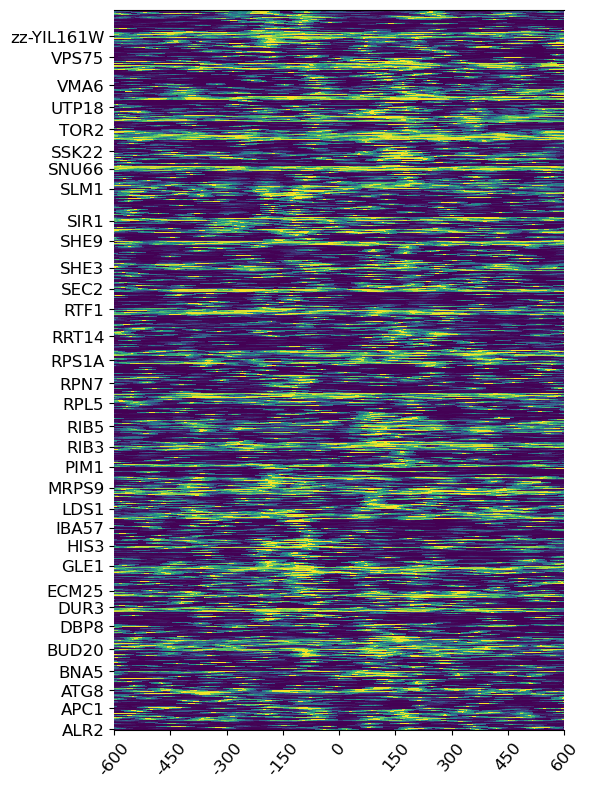

In [129]:
plt.figure(figsize=(5, 8))
pstart, pend = (-600, 600)
xticks_space = 150
ax = plt.axes((0.1, 0.1, 0.9, 0.9))
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(ticks= np.arange(pstart, pend+1, xticks_space))
ax.set_xticklabels(ax.get_xticks(), rotation = 50)
ax.set_xlim(pstart, pend)
height = (1, 1)
bottom=0
tick_yaxis, label_yaxis = [],[]
total, count = np.zeros(clustered_mtx.shape[1], dtype = int), np.zeros(clustered_mtx.shape[1], dtype = int)
(R,G,B) = colorMap(palette = 'viridis', log_scale=False)
thisgene = ''

for i in tqdm(range(clustered_mtx.shape[0])):
    left = -600
    if thisgene != clustered_genes[i]:
        tick_yaxis.append(bottom)
        label_yaxis.append(clustered_genes[i])
        thisgene = clustered_genes[i]
    for j in range(clustered_mtx.shape[1]):
        score = clustered_mtx[i, j]
        if not np.isnan(score):
            count[j] += score
            total[j] += 1
        # no score at this position
        if np.isnan(score):
            col = 'lightgray'
        else:
            color = int((score/256)*100)
            col=(R[color],G[color],B[color])
        thisalpha = 1
        rectangle = mplpatches.Rectangle([left, bottom-(height[0]*0.5)], 1, height[0], 
                                         facecolor = col, edgecolor = 'silver', linewidth = 0, alpha=thisalpha)
        ax.add_patch(rectangle)
        left += 1
    bottom +=height[0]

aggregate = np.divide(np.divide(count, total), 256)
if np.max(total) < 1:
    aggregate = np.zeros(clustered_mtx.shape[1])
ax.bar(np.arange(pstart, pend+1), aggregate, bottom=bottom, width = 1.0, color = 'tab:blue')
ax.set_yticks(ticks = tick_yaxis, labels = label_yaxis)
ax.set_ylim(0-0.5*height[0], bottom)

plt.savefig(fig_outpath+ f'6_top_well_positioned_genes_clustered_within_gene.pdf', bbox_inches='tight')